# Plots for paper

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import json 
import pandas as pd 
try:
    sys.path.remove("../py_src") # Hacky way to add higher directory to python modules path. 
except:
    pass
sys.path.append("../py_src") # Means that I dont have to make src/ a proper python package

In [4]:
from plotting import plot_custom_corner

In [5]:
def plot_all_corners(path,seed,save_id):


    #default values of GW parameters
    ranges=[(4e-7,6e-7),(-np.pi,np.pi),(0.0+1.0,np.pi+1.0),(0.0,np.pi/2.0),(-np.pi/2 + 0.8,np.pi/2 + 0.8),(0.0,np.pi),(0.5e-12,1.5e-12)]
    injection_parameters = [5e-7,0.20,2.50,1.0,1.0,1.0,1e-12]
    labels = [r'$\omega$',r'$\Phi_0$',r'$\psi$',r'$\iota$', r'$\delta$',r'$\alpha$',r'h']
    variables_to_plot = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw", "h"]
    axes_scales = None

    #Corner plot of GW parameters
    plot_custom_corner(path,variables_to_plot,labels,injection_parameters,ranges,axes_scales,savefig=f'{save_id}_GW')




    #Plot f0 
    pulsars = pd.read_csv("../data/NANOGrav_pulsars.csv")
    true_f = pulsars["F0"].to_numpy()


    labels = [r'$f_0$',r'$f_1$',r'$f_2$',r'$f_3$', r'$f_4$']
    idx = len(labels)
    injection_parameters = true_f[0:idx]
    variables_to_plot = ["f00", "f01", "f02", "f03", "f04"]

#    ranges = [(i*0.9,i*1.1) for i in injection_parameters]


    tol = 0.1
    ranges = [(i-np.abs(i*tol),i+np.abs(i*tol)) for i in injection_parameters]


    axes_scales = None
    plot_custom_corner(path,variables_to_plot,labels,injection_parameters,ranges,axes_scales,savefig=f'{save_id}_f' )


    #Plot f1
    true_f = pulsars["F1"].to_numpy()

    labels = [r'$\dot{f}_0$',r'$\dot{f}_1$',r'$\dot{f}_2$',r'$\dot{f}_3$', r'$\dot{f}_4$']
    idx = len(labels)
    injection_parameters = true_f[0:idx]
    variables_to_plot = ["fdot0", "fdot1", "fdot2", "fdot3", "fdot4"]

    tol = 0.1
    ranges = [(i-np.abs(i*tol),i+np.abs(i*tol)) for i in injection_parameters]
    axes_scales = None
    plot_custom_corner(path,variables_to_plot,labels,injection_parameters,ranges,axes_scales,savefig=f'{save_id}_fdot')


    #Plot sigma_p, log scaled
    generator = np.random.default_rng(seed)
    σp = generator.uniform(low = 1e-21,high=1e-19,size=len(true_f))

        
    labels = [r'$\sigma_p^0$',r'$\sigma_p^1$',r'$\sigma_p^2$',r'$\sigma_p^3$', r'$\sigma_p^4$']
    idx = len(labels)
    injection_parameters = σp[0:idx]
    variables_to_plot    = ["sigma_p0", "sigma_p1", "sigma_p2", "sigma_p3", "sigma_p4"]
    ranges = [(1e-22,1e-18) for i in injection_parameters]




    plot_custom_corner(path,variables_to_plot,labels,injection_parameters,ranges,axes_scales,savefig=f'{save_id}_sigma_p',logscale=True)




In [29]:
from system_parameters import SystemParameters
from pulsars import Pulsars

from synthetic_data import SyntheticData
from plotting import plot_statespace,plot_all
from model import LinearModel
from kalman_filter import KalmanFilter
from priors import priors_dict

import random
def single_run(h,measurement_model,seed,perturb_omega): 
    P   = SystemParameters(h=h,σp=None,σm=1e-11,use_psr_terms_in_data=True,measurement_model=measurement_model,seed=seed) # define the system parameters as a dict. Todo: make this a class
    PTA  = Pulsars(P)               # setup the PTA
    data = SyntheticData(PTA,P) # generate some synthetic data

    #Define the model 
    model = LinearModel(P)

    #Initialise the Kalman filter
    KF = KalmanFilter(model,data.f_measured,PTA)

    # Run the KFwith the correct parameters
    true_parameters = priors_dict(PTA,P)
    if perturb_omega:
        print("Perturbing the omega value from its truth")
        true_parameters["omega_gw"] = true_parameters["omega_gw"]*random.uniform(0.1, 2.0)
        print("New omega = ", true_parameters["omega_gw"])
        
    model_likelihood, model_state_predictions_x,model_state_predictions_y = KF.likelihood(true_parameters)
    print("Model likelihood is: ", model_likelihood)
    plot_all(PTA.t, data.intrinsic_frequency, data.f_measured,data.f_measured_clean,model_state_predictions_x,model_state_predictions_y, 1,savefig=None)

## Example 1: Run ID 1237, $h = 10^{-12}$

INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1237
INFO:root:You are assigning the σp terms randomly
INFO:root:You are including the PSR terms in your synthetic data generation
INFO:root:You are using the Earth terms measurement model


Model likelihood is:  -643200.4257978579
Mean residual: -5.482473050756915e-12


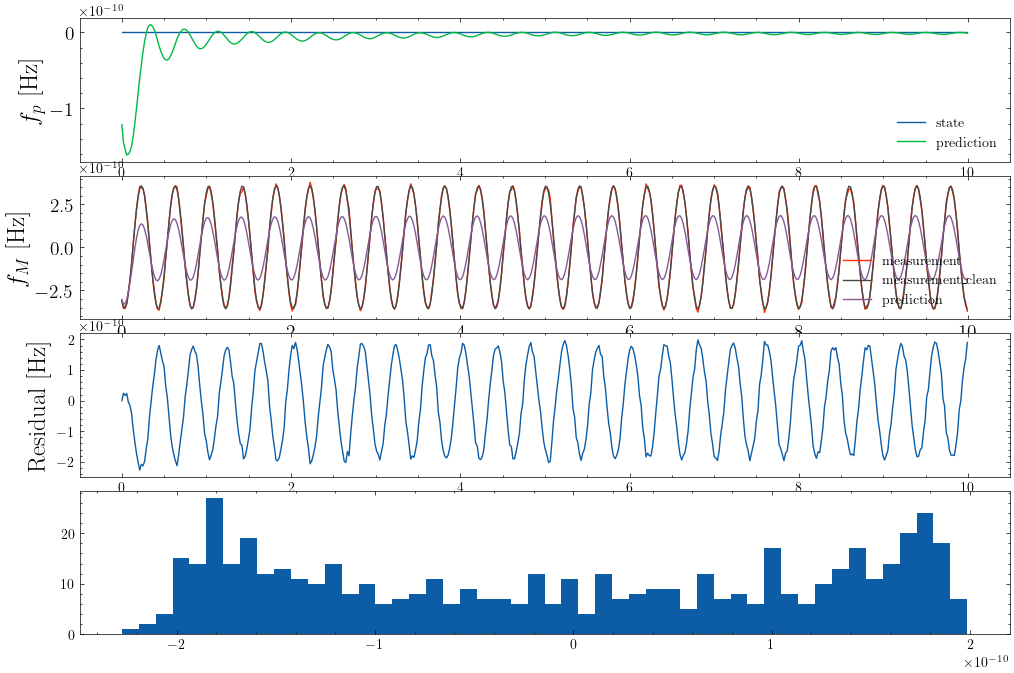

In [30]:
h = 1e-12
measurement_model = "earth"
seed = 1237
single_run(h,measurement_model,seed,perturb_omega=False)

INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1237
INFO:root:You are assigning the σp terms randomly
INFO:root:You are including the PSR terms in your synthetic data generation
INFO:root:You are using just the null measurement model


Model likelihood is:  -2410780.6364987902
Mean residual: -8.470905904106469e-12


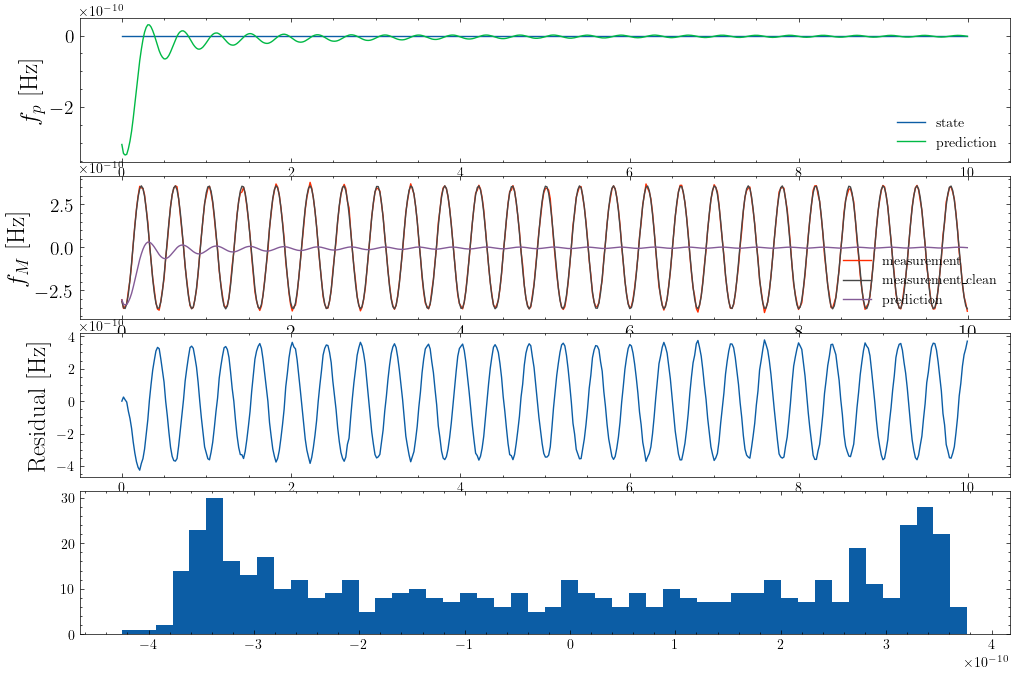

In [31]:
h = 1e-12
measurement_model = "null"
seed = 1237
single_run(h,measurement_model,seed,perturb_omega=False)

The evidence is: -538301.8875694362
Number of samples:
9818
Truths/Medians/Variances
$\omega$ 5e-07 5.000272884520703e-07 2.2804946758951492e-23
$\Phi_0$ 0.2 0.20020649823067377 6.733905611972165e-07
$\psi$ 2.5 2.597053250057101 2.929535920100646e-07
$\iota$ 1.0 0.9189336969129986 0.007413420490062122
$\delta$ 1.0 1.000809959072269 2.8188424607520623e-07
$\alpha$ 1.0 1.0405580330439217 1.7162225464222117e-07
h 1e-12 1.1903910025038017e-12 5.246445458285294e-27


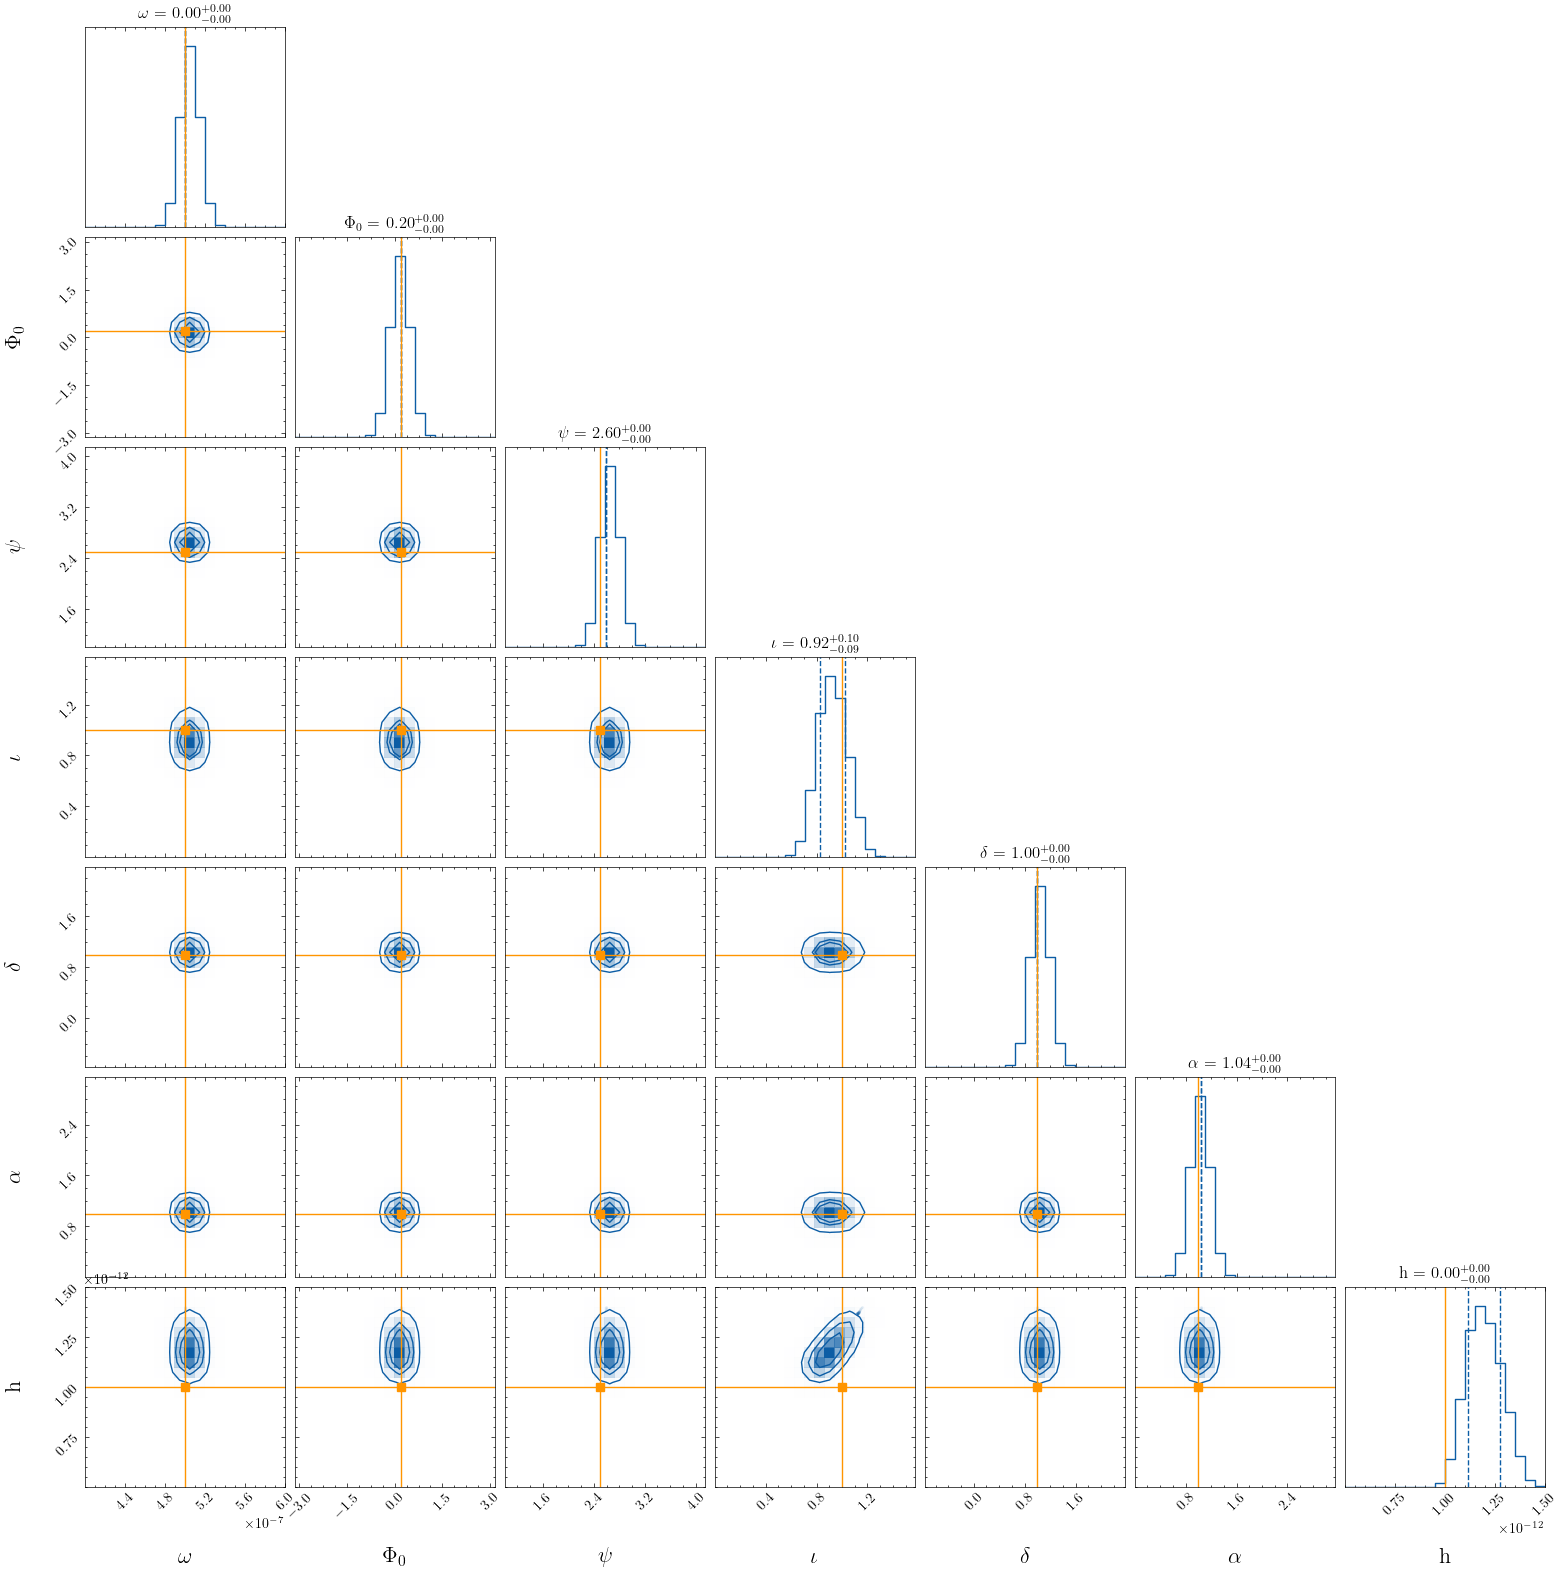

The evidence is: -538301.8875694362
Number of samples:
9818
Truths/Medians/Variances
$f_0$ 327.8470205611185 330.63559421948025 0.08902444712171481
$f_1$ 205.53069910059 206.950065209012 0.11172950446554342
$f_2$ 303.0909794113198 302.15961008314775 1.59067134470848
$f_3$ 326.600561967271 329.5239034761349 0.05349412274311007
$f_4$ 348.5592316999902 347.9765243703281 1.8780820221749257


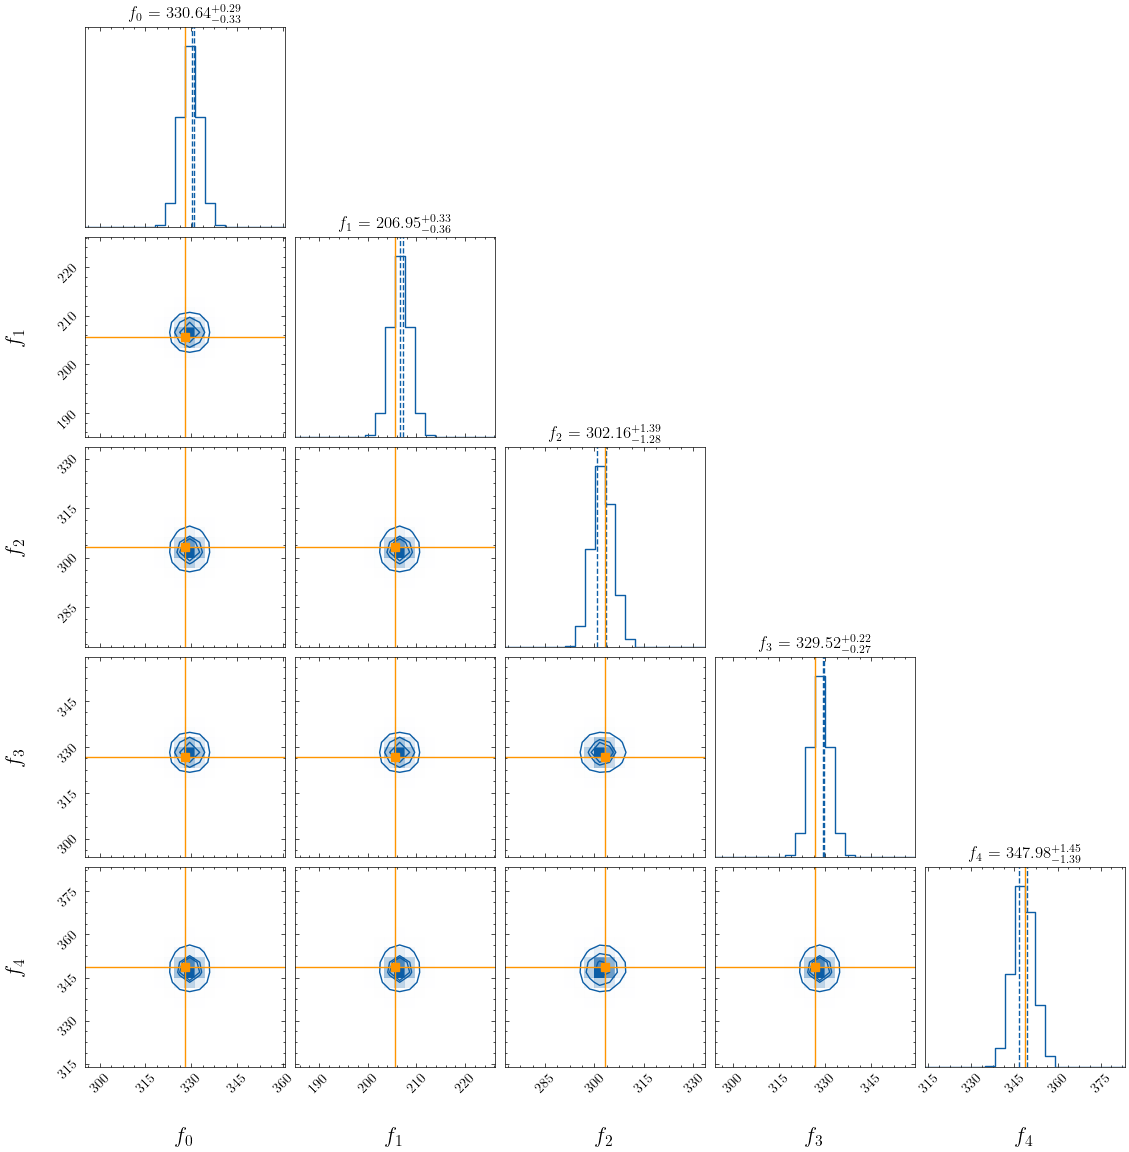

The evidence is: -538301.8875694362
Number of samples:
9818
Truths/Medians/Variances
$\dot{f}_0$ -1.227834e-15 -1.2292906286248653e-15 2.244714461322888e-35
$\dot{f}_1$ -4.297e-16 -4.3073484789793853e-16 3.455110574274327e-36
$\dot{f}_2$ -6.4737e-16 -6.433528144262555e-16 2.5144543120072826e-36
$\dot{f}_3$ -1.022991e-15 -1.0211281619164603e-15 1.9173598954354039e-35
$\dot{f}_4$ -4.1895e-16 -4.1948867565222406e-16 2.6850946330807807e-36


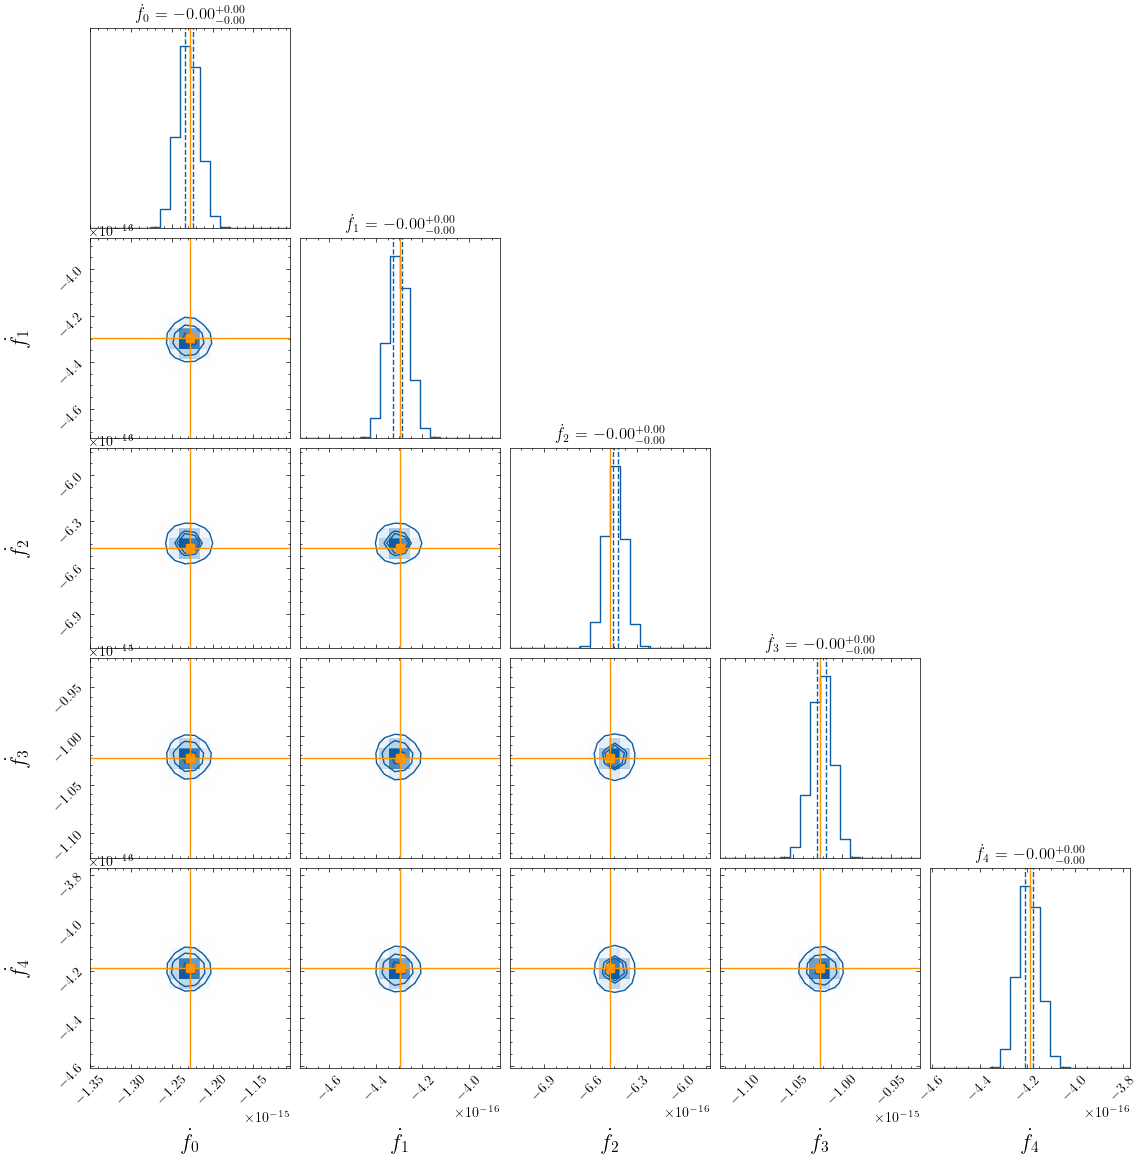

The evidence is: -538301.8875694362
Number of samples:
9818
Truths/Medians/Variances
$\sigma_p^0$ 9.769327690311607e-20 1.968534931153507e-20 5.287115421059771e-40
$\sigma_p^1$ 3.8639377766942156e-20 1.8173119737685806e-20 5.195067954741889e-40
$\sigma_p^2$ 9.240137714263159e-20 2.9261879208161296e-21 2.5141294697554355e-41
$\sigma_p^3$ 2.6907549962490873e-20 2.4807684091853698e-20 5.320265902011268e-40
$\sigma_p^4$ 3.2590608783005556e-20 1.9989891828055048e-20 5.476921194903035e-40


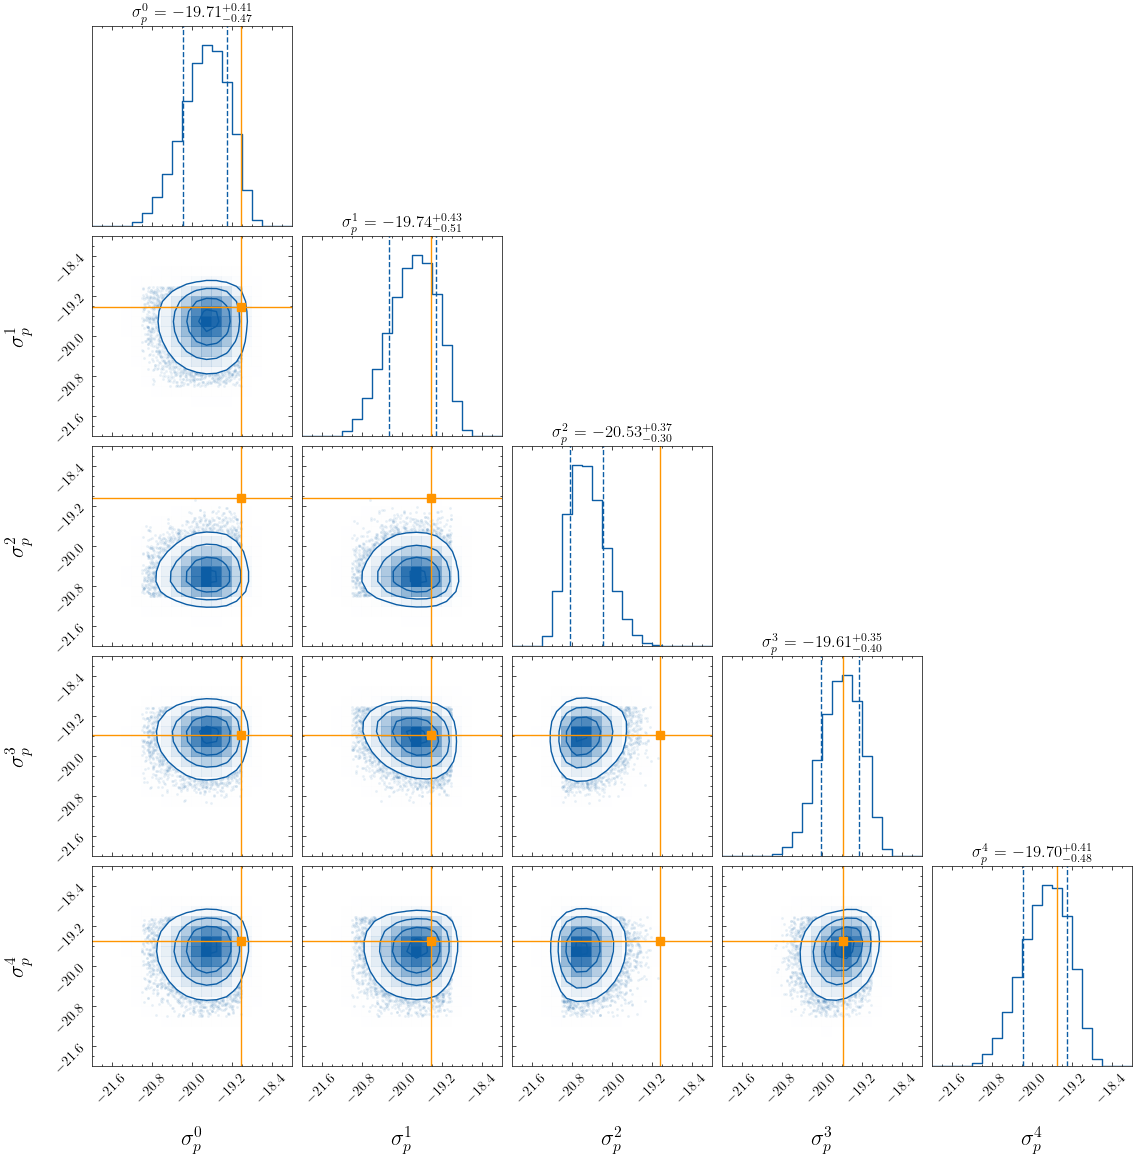

In [5]:
import numpy as np 
path = "../data/nested_sampling/scp_dir_noise/noise_batch_1246_result.json"
plot_all_corners(path,1234,save_id='1237_broad')

## Example 2: Run ID 1237, $h = 10^{-12}$, narrower priors on $\sigma_p$

The evidence is: -538677.3000651377
Number of samples:
9836
Truths/Medians/Variances
$\omega$ 5e-07 4.999956713530613e-07 2.1998240894556208e-23
$\Phi_0$ 0.2 0.1933770419688168 6.547371419198121e-07
$\psi$ 2.5 2.5962559662085445 3.1776818366396837e-07
$\iota$ 1.0 0.9767055650418923 0.007593820028455818
$\delta$ 1.0 1.0017163115419332 3.8236059922500053e-07
$\alpha$ 1.0 1.039557439694603 1.936508645152293e-07
h 1e-12 1.239221317579755e-12 5.460433003546534e-27


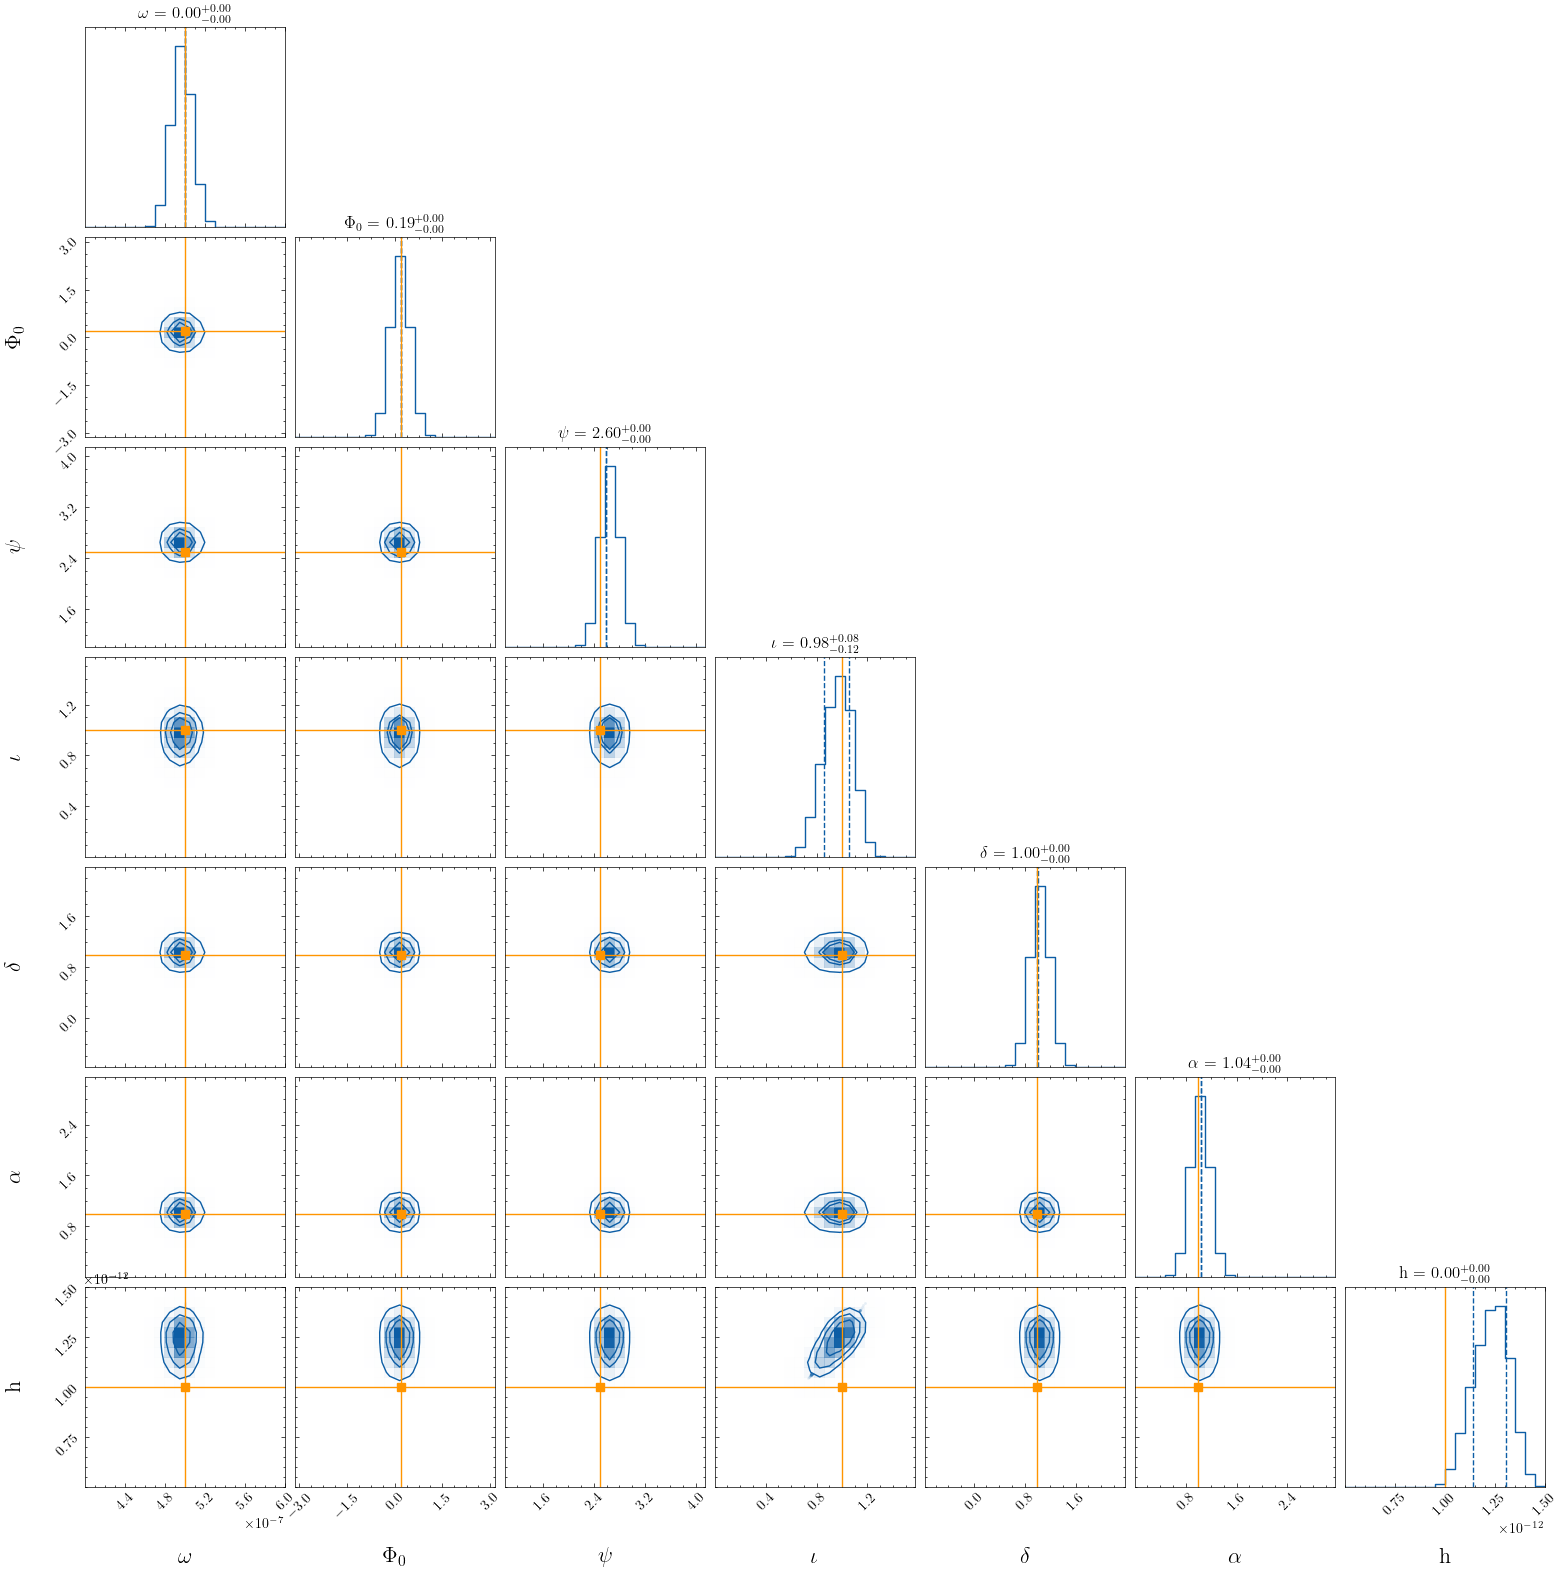

The evidence is: -538677.3000651377
Number of samples:
9836
Truths/Medians/Variances
$f_0$ 327.8470205611185 329.4254443199831 0.22260675980011554
$f_1$ 205.53069910059 207.02944853402727 0.0984984565426536
$f_2$ 303.0909794113198 302.9423808071124 2.023289508974191
$f_3$ 326.600561967271 329.2935000209259 0.110795739842539
$f_4$ 348.5592316999902 348.3448760713368 2.452717405984241


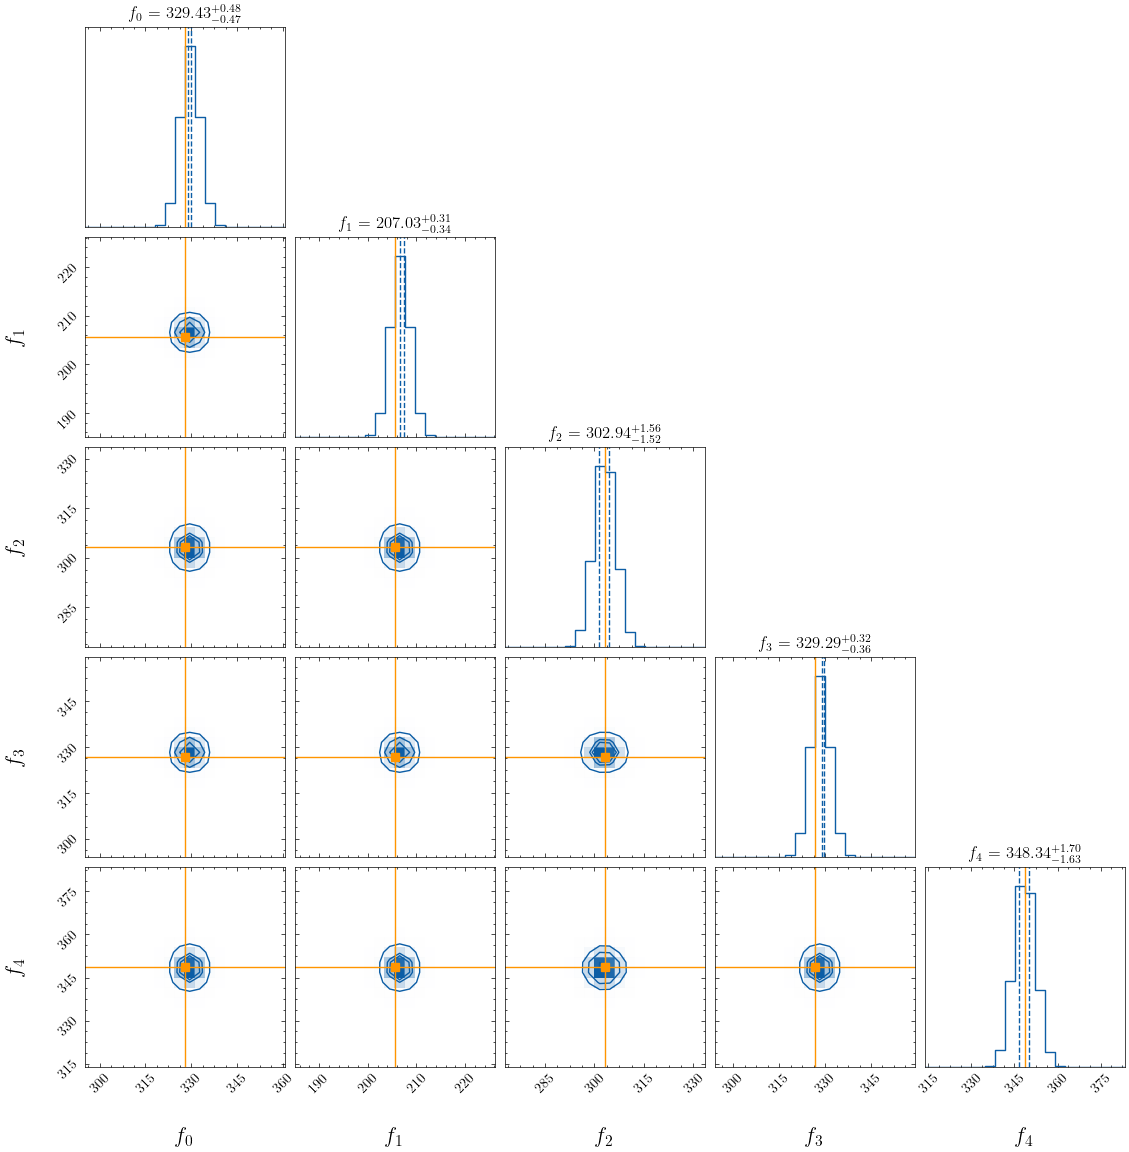

The evidence is: -538677.3000651377
Number of samples:
9836
Truths/Medians/Variances
$\dot{f}_0$ -1.227834e-15 -1.225212040456997e-15 2.78491075732231e-35
$\dot{f}_1$ -4.297e-16 -4.30880159712904e-16 2.1040035366880772e-36
$\dot{f}_2$ -6.4737e-16 -6.493305541179381e-16 7.65592811968548e-36
$\dot{f}_3$ -1.022991e-15 -1.0218319925150396e-15 2.0190923465198828e-35
$\dot{f}_4$ -4.1895e-16 -4.188181375987945e-16 3.160973008413512e-36


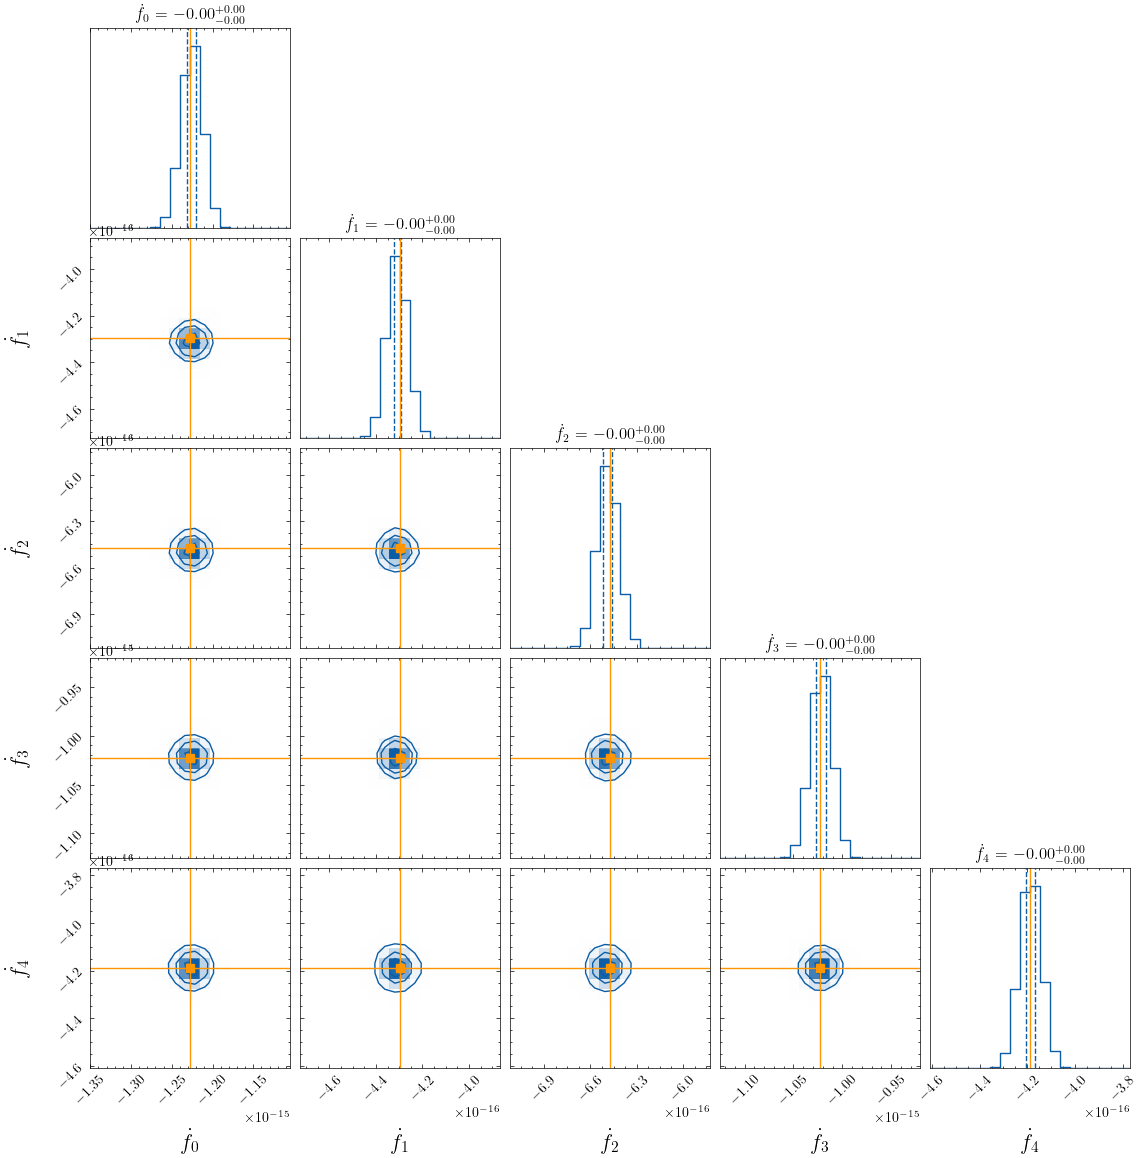

The evidence is: -538677.3000651377
Number of samples:
9836
Truths/Medians/Variances
$\sigma_p^0$ 5.054028399366765e-20 5.0425946926732e-20 4.711812090409937e-44
$\sigma_p^1$ 6.644933202006474e-20 6.605586724196175e-20 3.711563846638958e-44
$\sigma_p^2$ 2.4231055016152945e-20 2.426276146687015e-20 1.0095656824885672e-44
$\sigma_p^3$ 5.255055881680675e-21 5.273703451132293e-21 4.640188756596229e-46
$\sigma_p^4$ 4.059888409075103e-20 4.044646081940878e-20 2.78816439416726e-44


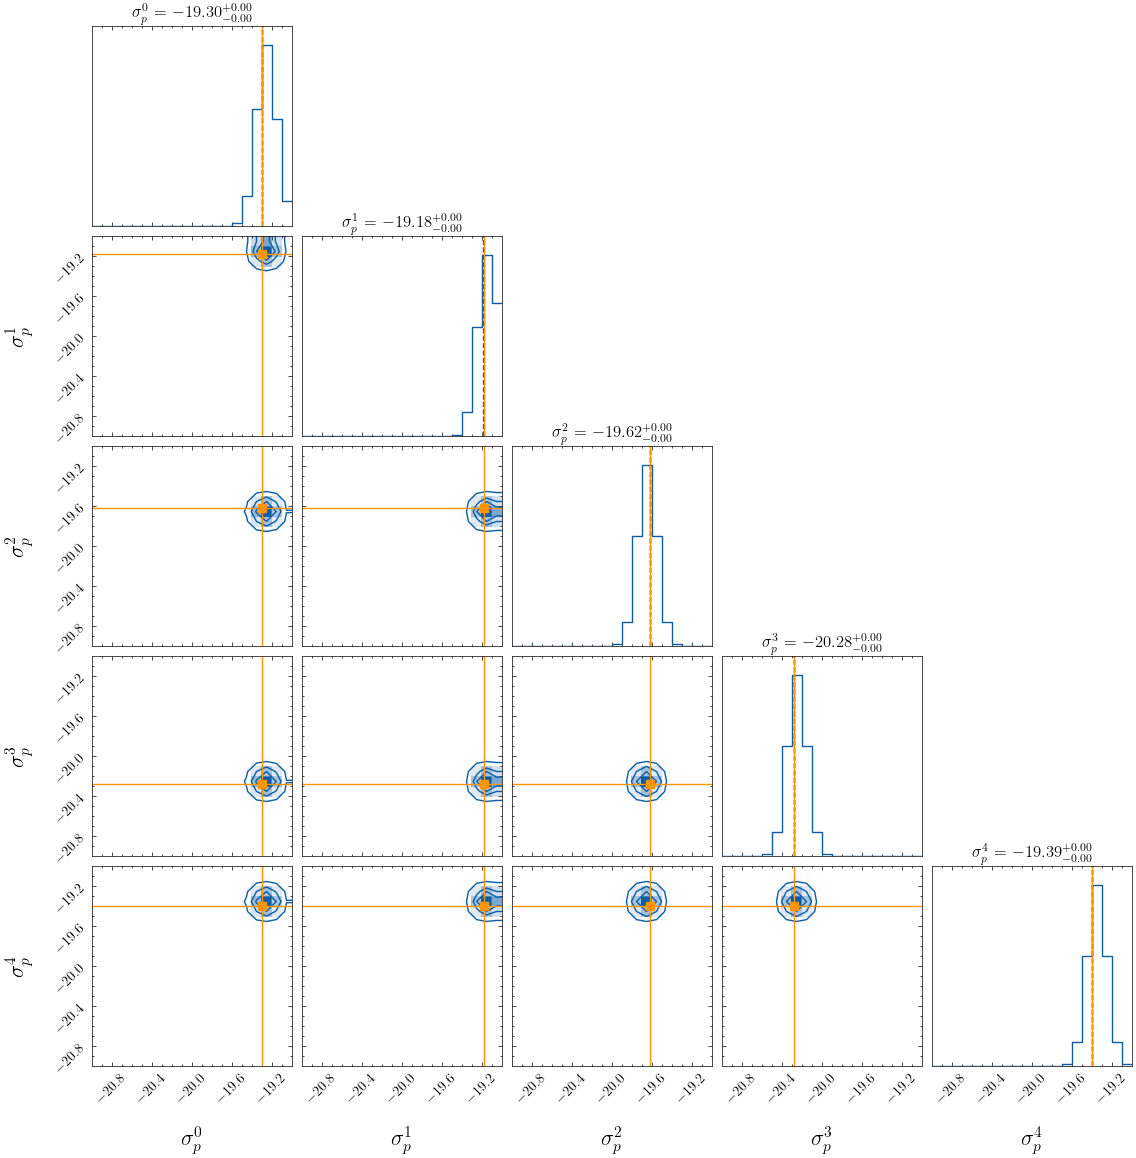

In [17]:
import numpy as np 
path = "../data/nested_sampling/batch_1237_result.json"
plot_all_corners(path,1237,save_id='1237_narrow')

In [3]:
import json 
import pandas as pd 

path = "../data/nested_sampling/batch_1237_result.json"


# Opening JSON file
f = open(path)

# returns JSON object as 
# a dictionary
data = json.load(f)
print("The evidence is:", data["log_evidence"])


#Make it a dataframe. Nice for surfacing
df_posterior = pd.DataFrame(data["posterior"]["content"]) # posterior



The evidence is: -538677.3000651377
